In [2]:
import pandas as pd
from pathlib import Path

RESULTS_DIR = Path("results")

In [ ]:
# Model 3
MODEL_3_DIR = RESULTS_DIR / "3"

summary = pd.DataFrame()
for tests_dir in MODEL_3_DIR.glob("*"):
    if not tests_dir.is_dir():
        continue
    for average_stats_file in tests_dir.glob("average_stats.csv"):
        average_stats = pd.read_csv(average_stats_file)
        # if average_stats.shape[0] == 0:
        #     print(f"No average stats for {average_stats_file}")
        #     continue
        average_stats["model"] = tests_dir.stem
        summary = pd.concat([summary, average_stats])


,noise_type,noisy_psnr,noisy_ssim,denoised_psnr,denoised_ssim,model
0,sigma15,24.797761,0.580705,32.598988,0.899849,LIVE1
1,sigma25,20.499918,0.409562,30.959504,0.878923,LIVE1
2,sigma55,14.234952,0.197063,19.734874,0.374176,LIVE1
3,bicubic2,27.707916,0.856800,30.062375,0.907895,LIVE1
4,bicubic3,25.198600,0.750376,26.688580,0.810093,LIVE1
...,...,...,...,...,...,...
5,bicubic4,24.754324,0.677635,25.964478,0.737510,CBSD68
6,jpeg10,25.834419,0.744482,27.152910,0.783907,CBSD68
7,jpeg20,28.152545,0.830378,29.479063,0.859985,CBSD68
8,jpeg30,29.474526,0.867647,30.816890,0.892115,CBSD68


In [15]:
print(summary["model"].unique())

['LIVE1' 'urban100' 'classic5' 'Set5' 'Set14' 'BSDS100' 'CBSD68']


In [31]:
selected_noise_for_each_dataset = {
    "CBSD68": ["sigma15", "sigma25", "sigma55"],
    "Set14": ["bicubic2", "bicubic3", "bicubic4"],
    "Set5": ["bicubic2", "bicubic3", "bicubic4"],
    "BSDS100": ["bicubic2", "bicubic3", "bicubic4"],
    "urban100": ["bicubic2", "bicubic3", "bicubic4"],
    "classic5": [ "jpeg10", "jpeg20", "jpeg30", "jpeg40"],
    "LIVE1": ["jpeg10", "jpeg20", "jpeg30", "jpeg40"],
}

filtered_summary = pd.DataFrame()

for dataset, selected_noise_types in selected_noise_for_each_dataset.items():
    # Filter rows for this dataset with selected noise types
    dataset_rows = summary[
        (summary['model'] == dataset) & 
        (summary['noise_type'].isin(selected_noise_types))
    ]
    filtered_summary = pd.concat([filtered_summary, dataset_rows])


# move model column to the first column
filtered_summary = filtered_summary[['model', 'noise_type', 'noisy_psnr', 'noisy_ssim', 'denoised_psnr', 'denoised_ssim']]
filtered_summary = filtered_summary[["model", "noise_type", "denoised_psnr", "denoised_ssim"]]

# set precision of denoised_psnr and denoised_ssim to 2
filtered_summary["denoised_psnr"] = filtered_summary["denoised_psnr"].round(2).astype(str)
filtered_summary["denoised_ssim"] = filtered_summary["denoised_ssim"].round(2).astype(str)

# rename columns
filtered_summary.rename(columns={"model": "Model", "noise_type": "Noise Type", "denoised_psnr": "Denoised PSNR", "denoised_ssim": "Denoised SSIM"}, inplace=True)

# filter out rows where dataset is in ["CBSD68"], 

gaussian_noise = filtered_summary[filtered_summary["Noise Type"].str.contains("sigma")]
bicubic_noise = filtered_summary[filtered_summary["Noise Type"].str.contains("bicubic")]
jpeg_noise = filtered_summary[filtered_summary["Noise Type"].str.contains("jpeg")]

gaussian_noise["Noise Type"] = gaussian_noise["Noise Type"].str.replace("sigma", "")
gaussian_noise.rename(columns={"Noise Type": "Gaussian Noise Level"}, inplace=True)
bicubic_noise["Noise Type"] = bicubic_noise["Noise Type"].str.replace("bicubic", "")
bicubic_noise.rename(columns={"Noise Type": "Bicubic Upsampling Factor"}, inplace=True)
jpeg_noise["Noise Type"] = jpeg_noise["Noise Type"].str.replace("jpeg", "")
jpeg_noise.rename(columns={"Noise Type": "JPEG Quality"}, inplace=True)


gaussian_noise.to_latex(buf="gaussian_noise.tex", index=False)
bicubic_noise.to_latex(buf="bicubic_noise.tex", index=False)
jpeg_noise.to_latex(buf="jpeg_noise.tex", index=False)



/tmp/ipykernel_1193237/3895025681.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaussian_noise["Noise Type"] = gaussian_noise["Noise Type"].str.replace("sigma", "")
/tmp/ipykernel_1193237/3895025681.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaussian_noise.rename(columns={"Noise Type": "Gaussian Noise Level"}, inplace=True)
/tmp/ipykernel_1193237/3895025681.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [108]:
cb_training_log_1 = pd.read_csv("logs/cb/log_20250922_001402.txt", sep="\t")
cb_training_log_2 = pd.read_csv("logs/cb/log_20250922_011737.txt", sep="\t")

cb_training_log_1["epoch"] = cb_training_log_1["epoch"].apply(lambda x: x + 1)
cb_training_log_2["epoch"] = cb_training_log_2["epoch"].apply(lambda x: x + 6)

cb_training_log = pd.concat([cb_training_log_1, cb_training_log_2])

In [109]:
cb_training_log["avg_loss"] = cb_training_log["avg_loss"].astype(float)
cb_training_log["epoch"] = cb_training_log["epoch"].astype(int)

# group by epoch and take the mean of avg_loss
cb_training_log = cb_training_log.groupby("epoch")["avg_loss"].mean().reset_index()


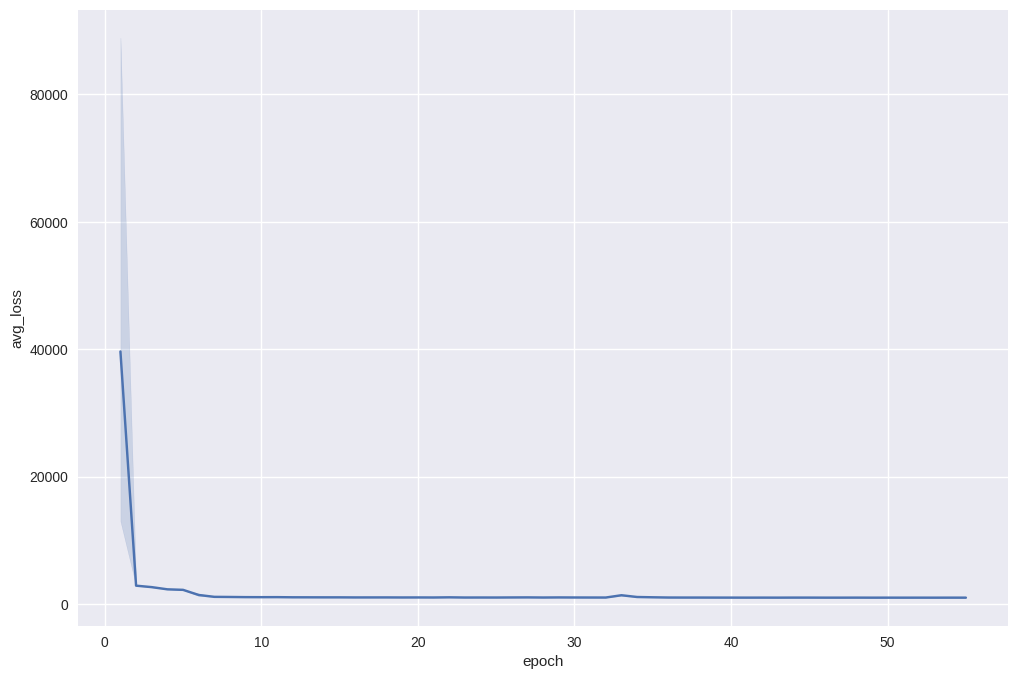

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="epoch", y="avg_loss", data=cb_training_log)
plt.show()


In [111]:
import random
model3_training_log = pd.read_csv("logs/3/log_20250922_105450.txt", sep="\t")

model3_training_log["epoch"] = model3_training_log["epoch"].apply(lambda x: x + 1)
model3_training_log["avg_loss"] = model3_training_log["avg_loss"].astype(float)
model3_training_log["epoch"] = model3_training_log["epoch"].astype(int)


# group by epoch and take the mean of avg_loss
model3_training_log = model3_training_log.groupby("epoch")["avg_loss"].mean().reset_index()


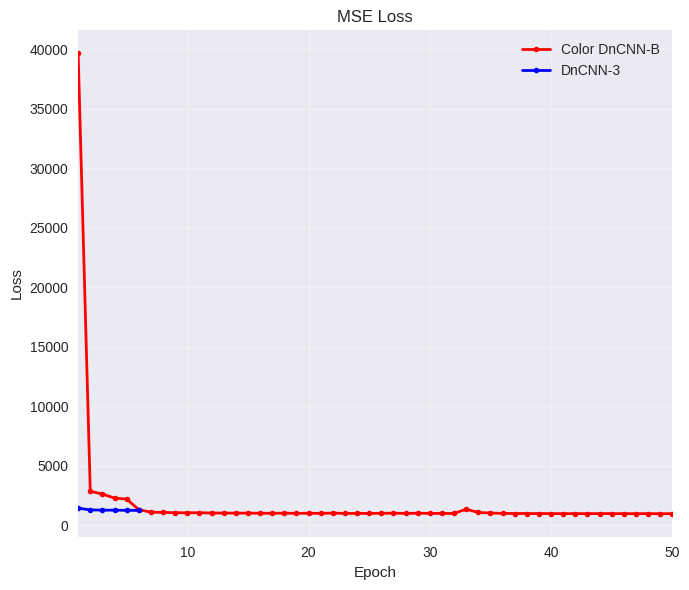

In [114]:
# plot average loss vs epoch

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# Create figure with 2 side-by-side subplots
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot 1: Loss through epochs (LEFT)
ax.plot(cb_training_log['epoch'], cb_training_log['avg_loss'], 'r-', linewidth=2, marker='o', markersize=4, label='Color DnCNN-B')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('MSE Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# log x
ax.plot(model3_training_log['epoch'], model3_training_log['avg_loss'], 'b-', linewidth=2, marker='o', markersize=4, label='DnCNN-3')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('MSE Loss')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(1,50)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
